## Librerías

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
import kaggle

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from keras.optimizers import SGD

from pickle import dump
from pickle import load

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'keras.src'

## Descargar e importar dataset

In [2]:
#kaggle.api.dataset_download_files(dataset='mlfinancebook/lending-club-loans-data', path='.', unzip=True, quiet=True)
dataset = read_csv('accepted_2007_to_2017.csv')

## Preparando los datos y Selección de características

In [3]:
# Ver los valores de la variable dependiente
dataset['loan_status'].value_counts(dropna=False)

loan_status
Current                                                788950
Fully Paid                                             646902
Charged Off                                            168084
Late (31-120 days)                                      23763
In Grace Period                                         10474
Late (16-30 days)                                        5786
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Default                                                    70
NaN                                                        23
Name: count, dtype: int64

In [4]:
# Solo nos interesa dos tipos de estado
dataset = dataset.loc[dataset['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [5]:
# Ver cantidad de cada clase
dataset['loan_status'].value_counts(dropna=False)

loan_status
Fully Paid     646902
Charged Off    168084
Name: count, dtype: int64

In [6]:
# En porcentaje
dataset['loan_status'].value_counts(normalize=True, dropna=False)

loan_status
Fully Paid     0.793758
Charged Off    0.206242
Name: proportion, dtype: float64

In [7]:
# Eliminar las columnas con más del 30% de falta de datos
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)
drop_list = missing_fractions[missing_fractions > 0.3].index
dataset = dataset.drop(labels=drop_list, axis=1)
dataset.shape

(814986, 92)

In [8]:
# Dejar solo las características relevantes para el objetivo
keep_list = ['charged_off','funded_amnt','addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code','last_pymnt_amnt','num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op',"bc_util","bc_open_to_buy","avg_cur_bal","acc_open_past_24mths" ]
drop_list = [col for col in dataset.columns if col not in keep_list]
dataset = dataset.drop(labels=drop_list, axis=1)
dataset.shape

(814986, 39)

In [9]:
# Label encoding de características
object_columns = dataset.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in object_columns:
    dataset[col] = dataset[col].astype(str)
    dataset[col] = le.fit_transform(dataset[col])

In [10]:
# Eliminar características con una correlación inferior al 30%
correlation = dataset.corr()
correlation_chargeOff = abs(correlation['loan_status'])
correlation_chargeOff.sort_values(ascending=False)
drop_list_corr = [col for col in correlation_chargeOff.index.tolist() if correlation_chargeOff[col] < 0.03]
dataset = dataset.drop(labels=drop_list_corr, axis=1)

In [11]:
# Remover más características irrelevantes
dataset = dataset.drop(labels=['id', 'emp_title'], axis=1)

In [12]:
# Poner la variable objetivo al final del dataframe
reordered_columns = dataset.columns.tolist()
reordered_columns.remove('loan_status')
reordered_columns.append('loan_status')
dataset = dataset[reordered_columns]
dataset = dataset.rename(mapper={'loan_status': 'charged_off'}, axis=1)

## Ingeniería de Características y Análisis exploratorio

In [13]:
# Tiempo de devolución del préstamo
dataset.groupby('term')['charged_off'].value_counts(normalize=True).loc[:, 1]

term
0    0.834290
1    0.666207
Name: proportion, dtype: float64

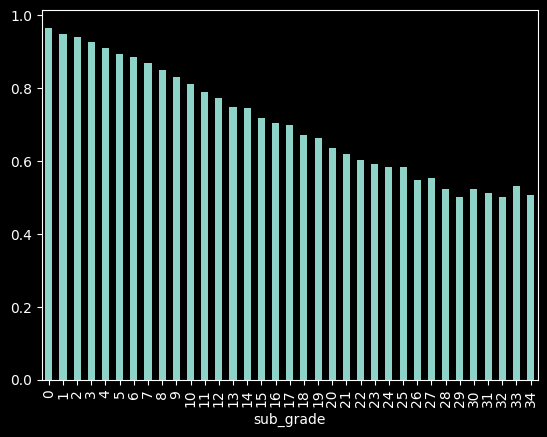

In [14]:
# Estudio de sub_grade
dataset.groupby('sub_grade')['charged_off'].value_counts(normalize=True).loc[:, 1].plot(kind='bar')
plt.show()

In [15]:
# Estudio de los ingresos de los prestamistas
dataset[['annual_inc']].describe()

,annual_inc
count,8.149860e+05
mean,7.523039e+04
std,6.524373e+04
min,0.000000e+00
25%,4.500000e+04
50%,6.500000e+04
75%,9.000000e+04
max,9.550000e+06


In [16]:
# Se aplica la compresión logarítmica para obtener valores menos dispersos
dataset['log_annual_inc'] = dataset['annual_inc'].apply(lambda x: np.log10(x+1))
dataset = dataset.drop(labels='annual_inc', axis=1)

In [17]:
# FICO score, notación de riesgo de crédito
dataset[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


In [18]:
# Para evitar redundancia se unen las dos en una columna
dataset['fico_score'] = 0.5 * dataset['fico_range_low'] + 0.5 * dataset['fico_range_high']
dataset = dataset.drop(labels=['fico_range_low', 'fico_range_high'], axis=1)

In [19]:
dataset.shape

(814986, 24)

In [20]:
# Submuestreo
undersampling = (
    dataset[dataset['charged_off']==dataset['charged_off']
            .value_counts().idxmax()]
            .sample(n=dataset['charged_off'].value_counts().min())
            )
dataset = pd.concat(
    [dataset[dataset['charged_off']==dataset['charged_off'].value_counts().idxmin()],
     undersampling]
    )
dataset['charged_off'].value_counts()

charged_off
0    168084
1    168084
Name: count, dtype: int64

In [21]:
# Rellenar los valores nulos con la media aritmética
dataset = dataset.fillna(dataset.mean())

In [22]:
# Dataset listo
dataset

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,dti,...,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off,log_annual_inc,fico_score
1,10400.0,10400.0,0,6.99,321.08,0,2,1,0,14.92,...,9536.000000,7599.000000,41.500000,290.00000,1.000000,1.000000,9.000000,0,4.763435,712.0
4,7650.0,7650.0,0,13.66,260.20,2,12,5,1,34.81,...,5857.000000,332.000000,93.200000,148.00000,8.000000,0.000000,4.000000,0,4.698979,687.0
8,23325.0,23325.0,0,14.31,800.71,2,13,5,1,27.03,...,39356.000000,3977.000000,89.000000,194.00000,15.000000,6.000000,5.000000,0,4.857339,667.0
10,10000.0,10000.0,0,11.99,332.10,1,9,5,2,8.44,...,4745.000000,324.000000,98.500000,124.00000,40.000000,0.000000,5.000000,0,4.954247,677.0
11,12975.0,12975.0,0,17.86,468.17,3,19,5,1,22.42,...,1571.000000,2604.000000,52.700000,122.00000,2.000000,0.000000,8.000000,0,4.778158,682.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390822,2800.0,2800.0,0,20.75,105.14,4,21,1,2,5.79,...,19613.000000,8542.592632,63.118972,233.00000,70.000000,1.000000,3.000000,1,4.260763,792.0
1528601,11000.0,11000.0,1,13.67,254.08,2,12,1,0,8.52,...,5218.000000,2067.000000,65.500000,99.00000,6.000000,1.000000,3.000000,1,4.698979,697.0
576659,13000.0,13000.0,0,15.61,454.55,3,15,5,1,16.37,...,2403.000000,3609.000000,69.400000,49.00000,16.000000,1.000000,6.000000,1,4.672107,667.0
269910,18000.0,18000.0,0,13.57,611.44,2,12,5,2,6.33,...,12514.737551,8542.592632,63.118972,177.53836,12.125342,1.642072,5.838802,1,4.643463,692.0


## Evaluar algoritmos y modelos

In [23]:
# Split de datos
Y = dataset['charged_off']
X = dataset.loc[:, dataset.columns != 'charged_off']
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [24]:
dataset.charged_off.value_counts()

charged_off
0    168084
1    168084
Name: count, dtype: int64

In [27]:
# parameters
num_folds = 10
scoring = 'roc_auc'

In [25]:
# Classification algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('NN', MLPClassifier()))
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

In [29]:
# K-flods cross validation
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = f'{name}: {cv_results.mean()} ({cv_results.std()})'
    print(msg)

LR: 0.9146014215961819 (0.002868163428287442)
LDA: 0.9203350377307272 (0.0012280445996290202)
KNN: 0.8934125001119965 (0.0016342426737814934)
CART: 0.8642412977969605 (0.0013626694278952671)
NB: 0.9168484892813871 (0.0011369396567930791)


In [ ]:
# visualización comparativa de algoritmos
fig = plt.figure()
fig.suptitle('Comparación de algoritmos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
plt.show()

In [ ]:
# Grid Boosting Tuning
n_estimators = [20, 180]
max_depth = [3, 5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
model = GradientBoostingClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid =GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print(f'#{rank} {mean} ({stdev}) with: {param}')

## Finalizar el modelo

In [ ]:
# Preparar el modelo
model = GradientBoostingClassifier(max_depth=5, n_estimators=180)
model.fit(X_train, Y_train)

In [ ]:
# estimar precisión en validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

In [ ]:
# Visualizar matriz de confusión
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index=np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicción'
sns.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={'size': 16})
plt.show()

In [ ]:
# Importancia de características
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()